In [1]:
import os; os.chdir('..')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
import glob
warnings.simplefilter('ignore')

from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

import glob

from scripts import datasources, models, variables

mm.initialize()

Loading model step 'auto_ownership'
Loading model step 'primary_mode_choice'
Loading model step 'WLCM'


In [2]:
persons_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_PER.csv')[
    ['SAMPN','PERNO','GEND', 'AGE', 'RACE1', 'NTVTY', 'LIC', 'JOBS', 'HOURS', 'WSCHED', 'EDUCA', 'DISAB']
]

In [3]:
hh_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_HH.csv')[
  ['SAMPN','HHVEH','HHBIC','VEHNEW','OWN','INCOM','HHSIZ']]

In [4]:
# accessibility tables
MTC_acc = pd.read_csv('/home/jayne/ual_model_workspace/fall-2018-models/data/MTC_TAZ_accessibility.csv')

In [5]:
trips_table = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/notebooks-emma/HWtrips_101418.csv',index_col = 0)

trips_table['SAMPN'] = trips_table['HHPER'].astype(str).str.slice(0,-1).astype(int)
trips_table['PERNO'] = trips_table['HHPER'].astype(str).str.slice(-1).astype(int)

trips_table = trips_table.merge(persons_df, on = ['SAMPN','PERNO'], how = 'left').merge(hh_df, on = 'SAMPN', how = 'left')


In [6]:
# Each row is a single trip.
# attributes wanted:
# Time of day leaving home for work, time of day leaving work
# home zone, work zone
# mode (recode)
# gender, age, race, ntvty, lic, jobs (>1 binary), full_time (hours<40 binary), education, disability, flexible work schedule (to dummies?)
# attributes from skims

In [7]:
na_dict = {
    'GEND':[9],
    'AGE':[998,999],
    'RACE1':[97,98,99],
    'NTVTY':[8,9],
    'LIC':[8,9],
    'JOBS':[98,99],
    'HOURS':[998,999],
    'EDUCA':[7,8,9],
    'WSCHED':[8,9],
    'DISAB':[8,9],
    'HHVEH':[98,99],
    'HHBIC':[98,99],
    'VEHNEW':[8,9],
    'OWN':[7,8,9],
    'INCOM':[98,99],
    'HHSIZ':[98,99]
}

for col in na_dict:
    for vals in na_dict[col]:
        trips_table[col] = trips_table[col].replace(vals,np.nan)
        
trips_table.dropna(inplace = True)

In [8]:
TOD_list = ['EA','AM','MD','PM','EV']
var_list = ['Distance','Cost','Time']
skim_dir = '/home/data/fall_2018/mtc_skims'
skim_dict = dict()
for var in var_list:
    df_base = pd.read_csv(skim_dir + f'/{var}SkimsDatabaseEA.csv').replace(-999, 9999)
    df_base['TOD'] = 'EA'
    for TOD in TOD_list[1:]:
        df_tod = pd.read_csv(skim_dir + f'/{var}SkimsDatabase{TOD}.csv').replace(-999, 9999)
        df_tod['TOD'] = TOD
        df_base = pd.concat([df_base, df_tod])
    skim_dict[var] = df_base
        


# Time of day definitions

• Early (3:00 AM to 5:59 AM)
• AM peak (6:00 AM to 8:59 AM)
• Midday (9:00 AM to 3:29 PM)
• PM peak (3:30 PM to 6:29 PM)
• Late (6:30 PM to 2:59 AM)
EA, AM, MD, PM, EV

In [9]:
mode_dict = dict(zip(['drive_alone', 'shared',
                      'WTranW','DrTranW','WTranDr',
                      'bike', 'walk'],range(7)))
trips_table['MODE'] = trips_table['MODE'].replace(mode_dict)

In [10]:
trips_table['TOD'] = (
    ((trips_table.origin_ET.between(3,6,inclusive = False)) | (trips_table.origin_ET==3))*1 +
    ((trips_table.origin_ET.between(6,9,inclusive = False)) | (trips_table.origin_ET==6))*2 +
    ((trips_table.origin_ET.between(9,15.5,inclusive = False)) | (trips_table.origin_ET==9))*3 +
    ((trips_table.origin_ET.between(15.5,18.5,inclusive = False)) | (trips_table.origin_ET==15.5))*4 +
    ((trips_table.origin_ET>=18.5))*5 +
    ((trips_table.origin_ET.between(0,3,inclusive = False)) | (trips_table.origin_ET==0))*5
)
TOD_dict = dict(zip(range(1,6),TOD_list))
trips_table['TOD'] = trips_table['TOD'].replace(TOD_dict)


In [11]:
trips_table1 = trips_table.copy()
for var in var_list:
    trips_table1 = trips_table1.merge(skim_dict[var].rename(
        columns = dict(zip([i for i in skim_dict[var].columns if i not in ['orig','dest','TOD']],
         [i+ f'_{var}' for i in skim_dict[var].columns if i not in ['orig','dest','TOD']]))                                          
                                           ), how = 'left',left_on = ['Ozone','Dzone','TOD'], 
    right_on = ['orig','dest','TOD'])
    trips_table1.drop(['orig','dest'],axis = 1,inplace = True)

In [12]:
# join accessibility
trips_table1 = trips_table1.merge(MTC_acc, how = 'left',left_on = 'Ozone', right_on = 'taz1454')
trips_table1[MTC_acc.columns] = trips_table1[MTC_acc.columns].fillna(0)

In [13]:
@orca.table(cache=True)
def trips():
    return trips_table1

In [14]:
# mode_dict = dict(zip(['drive_alone', 'shared','WTranW','DrTranW','WTranDr','bike', 'walk'],range(7)))
        
m = SmallMultinomialLogitStep()
m.name = 'primary_mode_choice'
m.tables = ['trips']
m.choice_column = 'MODE'
m.model_expression = OrderedDict([
    ('intercept', [1,2,3,4,5,6]), 
    ('GEND',[2,3,4,5,6]),
    ('AGE',[2,3,4,5,6]),
    ('RACE1',[2,3,4,5,6]),
    ('NTVTY',[2,3,4,5,6]),
    ('LIC',[2,3,4,5,6]),
    ('JOBS',[2,3,4,5,6]),
    ('HOURS',[2,3,4,5,6]),
    ('WSCHED',[2,3,4,5,6]),
    ('EDUCA',[2,3,4,5,6]),
    ('DISAB',[2,3,4,5,6]),
    ('HHVEH',[2,3,4,5,6]),
       ('HHBIC',[2,3,4,5,6]),
    ('VEHNEW',[2,3,4,5,6]),
    ('OWN',[2,3,4,5,6]),
    ('INCOM',[2,3,4,5,6]),
    ('HHSIZ',[2,3,4,5,6]),
    
    
    ('da_Distance',[0]),
    ('da_Cost',[0]),
    ('da_Time',[0]),
    ('da_15',[0]),
    ('s2_Distance',[1]),
    ('s2_Cost',[1]),
    ('s2_Time',[1]),    
    ('da_15',[1]),
    ('wTrnW_Cost',[2]),
    ('wTrnW_Time',[2]),
    ('wTrnW_15',[2]),
    ('dTrnW_Cost',[3]),
    ('dTrnW_Time',[3]),
    ('wTrnD_Time',[4]),
    ('wTrnD_Cost',[5]),
    ('bike_Distance',[5]),
    ('bike_Time',[5]),   
    ('bike_15',[5]),
    ('walk_Distance',[6]),
    ('walk_Time',[6]),  
    ('walk_15',[6])
    
    
    
    
])

In [15]:
m.fit()

Log-likelihood at zero: -15,649.0094
Initial Log-likelihood: -15,649.0094
Estimation Time for Point Estimation: 10.43 seconds.
Final log-likelihood: -5,514.4482
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:                8,042
Model:             Multinomial Logit Model   Df Residuals:                    7,936
Method:                                MLE   Df Model:                          106
Date:                     Wed, 28 Nov 2018   Pseudo R-squ.:                   0.648
Time:                             23:16:01   Pseudo R-bar-squ.:               0.641
AIC:                            11,240.896   Log-Likelihood:             -5,514.448
BIC:                            11,982.094   LL-Null:                   -15,649.009
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [16]:
m.run()

In [17]:
m.tags = ['mode_choice','jayne','test']
m.register()

Model saved to configs/primary_mode_choice.pkl
Saving 'primary_mode_choice.yaml': /home/jayne/ual_model_workspace/fall-2018-models/configs
Loading model step 'primary_mode_choice'


In [18]:
# Validation process
from scripts import validate
validate.tp_rates(m)

,0,1,2,3,4,5,6,all
True Positive rate,0.981719,0,0.493952,0.0564516,0.0136986,0.123675,0.176829,0.801791


In [19]:
predicted_choices = validate.get_predicted_choices(m)
pd.crosstab(m.choices.rename('observed'), predicted_choices, margins=True) # unnormalized

predicted,0,2,3,4,5,6,All
observed,,,,,,,
0,6122,77,9,3,16,9,6236
1,390,5,0,0,1,0,396
2,225,245,2,3,7,14,496
3,206,19,14,9,0,0,248
4,191,23,1,3,1,0,219
5,221,21,1,0,35,5,283
6,96,33,0,0,6,29,164
All,7451,423,27,18,66,57,8042


In [20]:
validate.model_crosstab(m) # normalized by index

predicted,0,2,3,4,5,6
observed,,,,,,
0,0.981719,0.012348,0.001443,0.000481,0.002566,0.001443
1,0.984848,0.012626,0.000000,0.000000,0.002525,0.000000
2,0.453629,0.493952,0.004032,0.006048,0.014113,0.028226
3,0.830645,0.076613,0.056452,0.036290,0.000000,0.000000
4,0.872146,0.105023,0.004566,0.013699,0.004566,0.000000
5,0.780919,0.074205,0.003534,0.000000,0.123675,0.017668
6,0.585366,0.201220,0.000000,0.000000,0.036585,0.176829


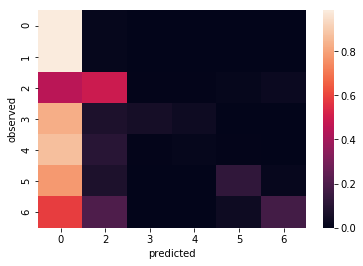

In [21]:
sns.heatmap(validate.model_crosstab(m))